In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


# Load data
df = pd.read_csv("ames.csv")


# Utility functions from Tutorial
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

<ipython-input-1-9035df87d369>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


let's review the meaning of mutual information by looking at a few features from the *Ames* dataset.

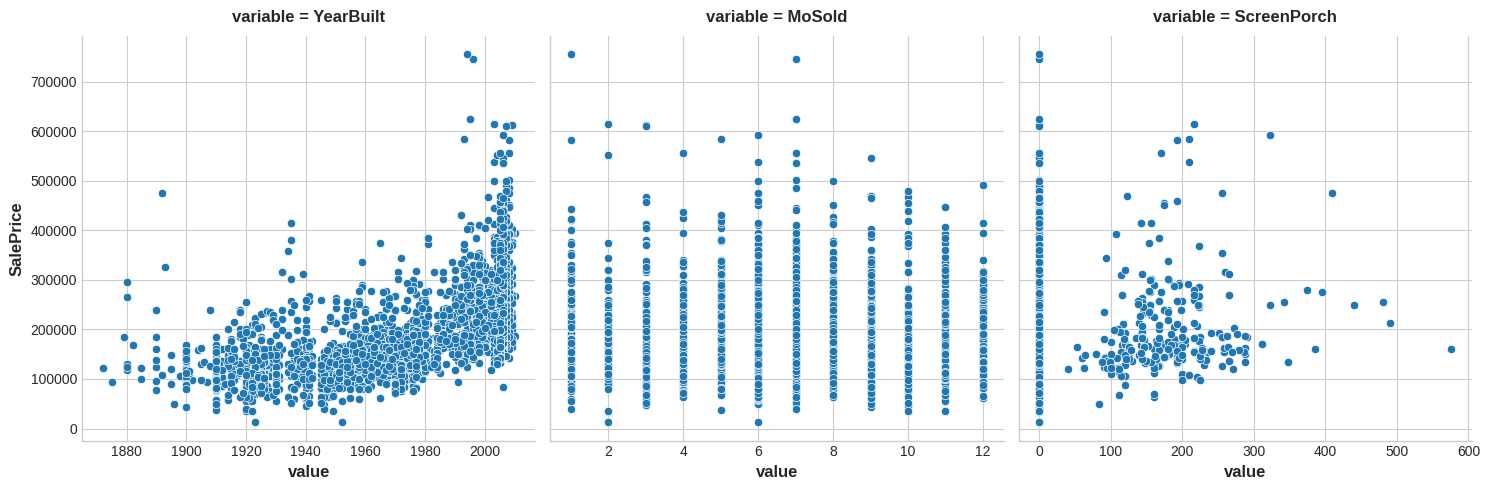

In [2]:
features = ["YearBuilt", "MoSold", "ScreenPorch"]
sns.relplot(
    x="value", y="SalePrice", col="variable", data=df.melt(id_vars="SalePrice", value_vars=features), facet_kws=dict(sharex=False),
);

# 1) Understand Mutual Information

Based on the plots, which feature do you think would have the highest mutual information with `SalePrice`?

In [7]:
X = df.copy()
y = X.pop("SalePrice")
mi_scores = mutual_info_regression(X[features], y)
mi_scores_df = pd.DataFrame(mi_scores, index=features, columns=["Mutual Information"])
mi_scores_df = mi_scores_df.sort_values(by="Mutual Information", ascending=False)

print(mi_scores_df)

             Mutual Information
YearBuilt              0.395737
ScreenPorch            0.013602
MoSold                 0.000000


#Write Your Answer here :
From the above code we can see the YearBuilt has the highest mutual information with SalePrice

-------------------------------------------------------------------------------

The *Ames* dataset has seventy-eight features -- a lot to work with all at once! Fortunately, you can identify the features with the most potential.

Use the `make_mi_scores` function to compute mutual information scores for the *Ames* features:


In [8]:
X = df.copy()
y = X.pop('SalePrice')

mi_scores = make_mi_scores(X, y)

Now examine the scores using the functions in this cell. Look especially at top and bottom ranks.


OverallQual     0.581262
Neighborhood    0.569813
GrLivArea       0.496909
YearBuilt       0.437939
GarageArea      0.415014
TotalBsmtSF     0.390280
GarageCars      0.381467
FirstFlrSF      0.368825
BsmtQual        0.364779
KitchenQual     0.326194
ExterQual       0.322390
YearRemodAdd    0.315402
MSSubClass      0.287131
GarageFinish    0.265440
FullBath        0.251693
Foundation      0.236115
LotFrontage     0.233334
GarageType      0.226117
FireplaceQu     0.221955
SecondFlrSF     0.200658
Name: MI Scores, dtype: float64


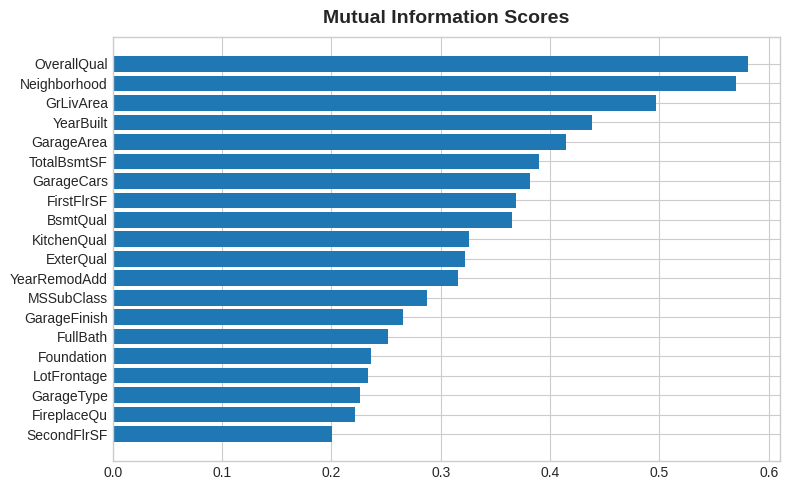

In [9]:
print(mi_scores.head(20))
# print(mi_scores.tail(20))  # uncomment to see bottom 20

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))
# plot_mi_scores(mi_scores.tail(20))  # uncomment to see bottom 20

# 2) Examine MI Scores

Do the scores seem reasonable? Do the high scoring features represent things you'd think most people would value in a home? Do you notice any themes in what they describe?

#Write your answers here :
The mutual information scores are likely to reflect reasonable and expected trends in home valuation. Features that score high typically align with common buyer preferences such as home quality, size, age, and condition. These factors are often critical in determining a home's market value, and thus, they should have significant mutual information with SalePrice.

Themes noticed are Quality and Condition , Space and Size and Age and Modernity

-------------------------------------------------------------------------------

In this step you'll investigate possible interaction effects for the `BldgType` feature. This feature describes the broad structure of the dwelling in five categories:

> Bldg Type (Nominal): Type of dwelling
>
>       1Fam	Single-family Detached
>       2FmCon	Two-family Conversion; originally built as one-family dwelling
>       Duplx	Duplex
>       TwnhsE	Townhouse End Unit
>       TwnhsI	Townhouse Inside Unit

The `BldgType` feature didn't get a very high MI score. A plot confirms that the categories in `BldgType` don't do a good job of distinguishing values in `SalePrice` (the distributions look fairly similar, in other words):

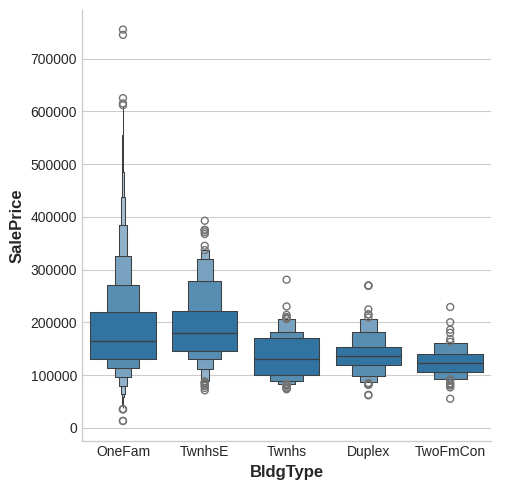

In [10]:
sns.catplot(x="BldgType", y="SalePrice", data=df, kind="boxen");

Still, the type of a dwelling seems like it should be important information. Investigate whether `BldgType` produces a significant interaction with either of the following:

```
GrLivArea  # Above ground living area
MoSold     # Month sold
```

Run the following cell twice, the first time with `feature = "GrLivArea"` and the next time with `feature="MoSold"`:

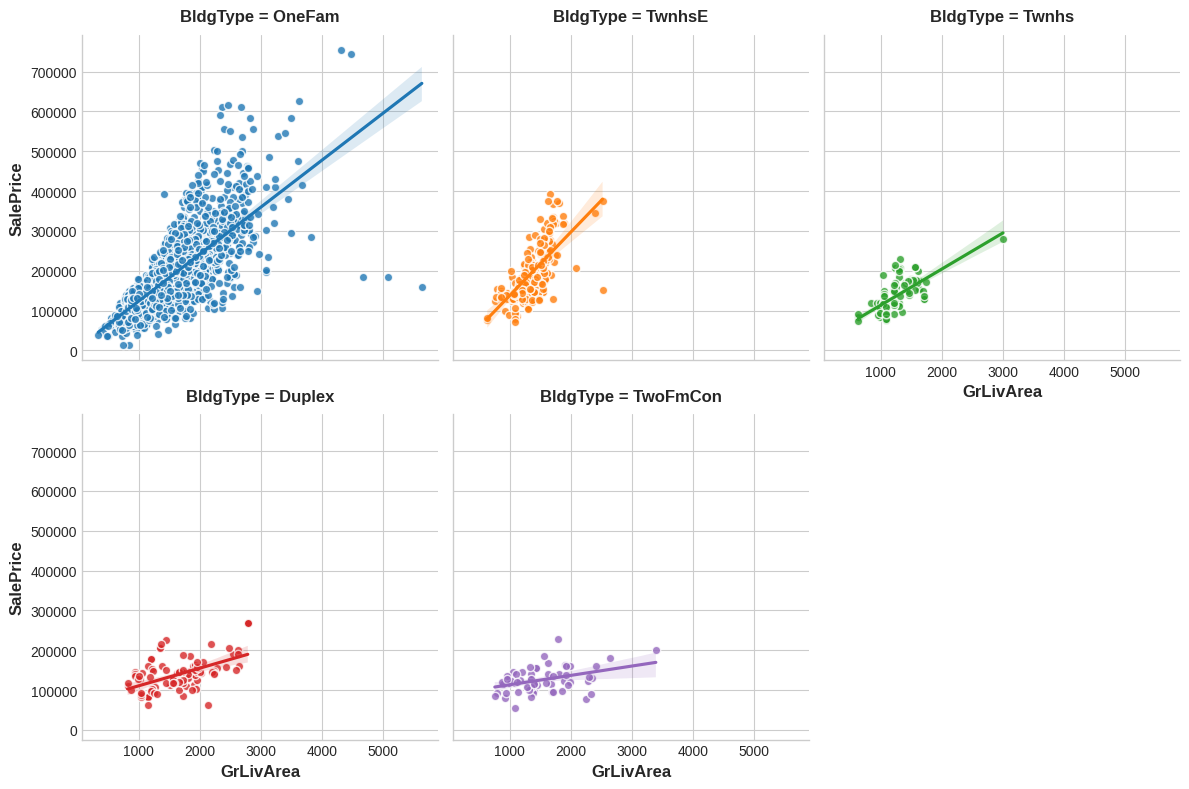

In [11]:
# YOUR CODE HERE:
feature = "GrLivArea"

sns.lmplot(
    x=feature, y="SalePrice", hue="BldgType", col="BldgType",
    data=df, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4,
);

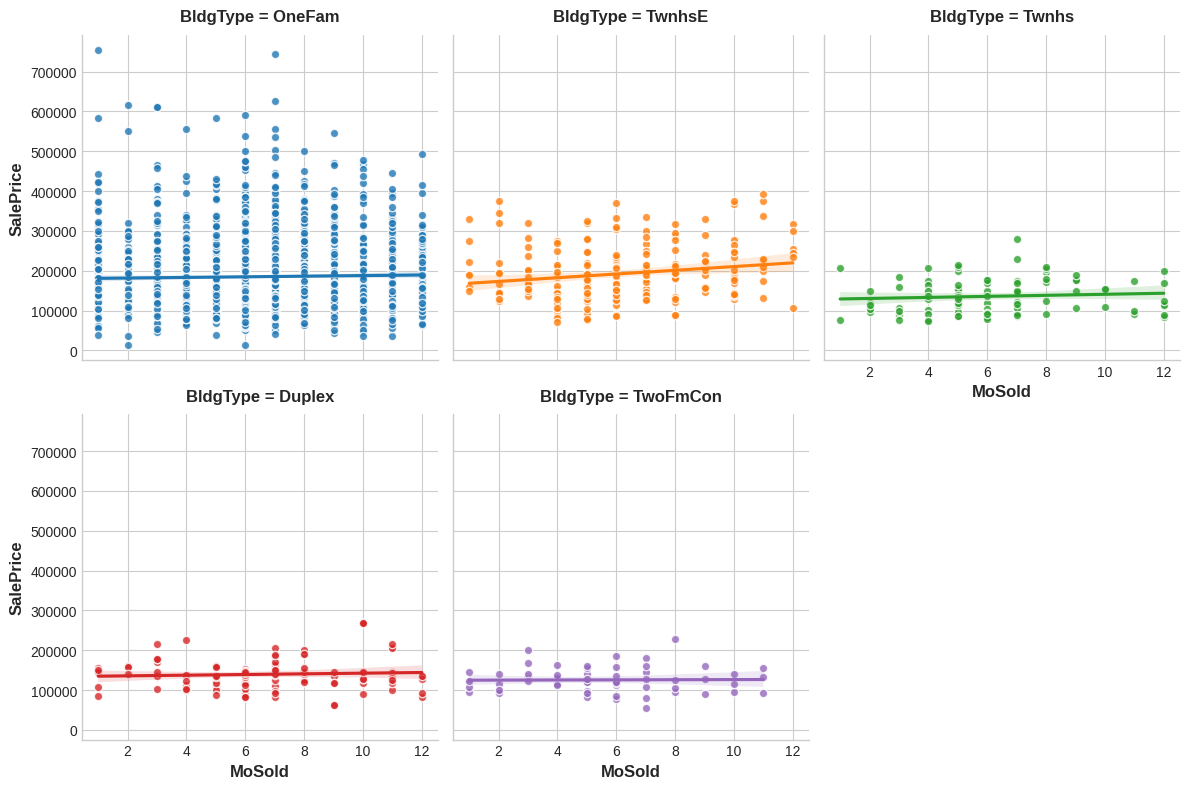

In [12]:
feature = "MoSold"

sns.lmplot(
    x=feature, y="SalePrice", hue="BldgType", col="BldgType",
    data=df, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4,
);

The trend lines being significantly different from one category to the next indicates an interaction effect.

# 3) Discover Interactions

From the plots, does `BldgType` seem to exhibit an interaction effect with either `GrLivArea` or `MoSold`?

#Write your answers here :
The slopes of either GrLivArea or MoSold doesnot seem to change with the BldgType so I assume that there is no interaction effect

# A First Set of Development Features #

Let's take a moment to make a list of features we want based on the MI scores.

You found that the ten features with the highest MI scores were:

In [13]:
mi_scores.head(10)

OverallQual     0.581262
Neighborhood    0.569813
GrLivArea       0.496909
YearBuilt       0.437939
GarageArea      0.415014
TotalBsmtSF     0.390280
GarageCars      0.381467
FirstFlrSF      0.368825
BsmtQual        0.364779
KitchenQual     0.326194
Name: MI Scores, dtype: float64

Do you recognize the themes here? Location, size, and quality. You needn't restrict development to only these top features, but you do now have a good place to start. Combining these top features with other related features, especially those you've identified as creating interactions, is a good strategy for coming up with a highly informative set of features to train your model on.